In [101]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import AverageMeter
import time
import subprocess as sp
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from custom_model import ConvNet

In [70]:
#test transforms
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4913997551666284, 0.48215855929893703, 0.4465309133731618),std=(0.24703225141799082, 0.24348516474564, 0.26158783926049628)),
])

In [73]:
def test_preprocess(path,transforms=transform_test): #function to preprocess test data
    cifar10_test = datasets.CIFAR10(root=path, train=False, download=True, transform=transforms)
    digit_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    test_indices = [i for i, (_, label) in enumerate(cifar10_test) if label in digit_classes]
    test_subset = Subset(cifar10_test, test_indices)
    return test_subset

In [107]:
def initialize_segmentation_model(checkpoint_path, model_name='resnet50', num_classes=10, device=0,old=0): # function to initialise model
    if model_name == 'custom':
        model = ConvNet()
    else :
        model = timm.create_model(model_name, num_classes=num_classes, pretrained=True)
        
    checkpoint = torch.load(checkpoint_path,map_location={f'cuda:{old}': 'cuda:' + str(device)},weights_only=True)    
    model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    model = model.to(torch.device('cuda:' + str(device)))
    model.eval()
    return model

def get_memory_usage(device): #To compute memory usage, in GB
    device = device.index
    command = f'nvidia-smi --query-gpu=memory.used --id={device} --format=csv'
    out = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    used_memory = float(out[0].split()[0])
    return used_memory/1e3

def test_model(model, device, test_loader): # function to test the model
    model.eval()
    all_predictions = [] #update
    all_targets = [] #update
    batch_time = AverageMeter()
    data_time = AverageMeter()
    start_epoch_time = time.time()
    print("Testing...")
    with torch.no_grad():
        progress_bar = tqdm(test_loader)
        for batch_idx,(img, label) in enumerate(progress_bar):
            data_time.update(time.time() - start_epoch_time)
            img, label = img.to(device = device), label.to(device = device)
            output = model(img)
            preds = torch.argmax(torch.nn.Softmax(dim = 1)(output),dim = 1)
            all_predictions.extend(preds.cpu().numpy()) #update
            all_targets.extend(label.squeeze().cpu().numpy()) # update
            batch_time.update(time.time() - start_epoch_time)
            start_epoch_time = time.time()
            progress_bar.set_description('({batch}/{size}) | Data: {data:.3f}s | Batch: {bt:.3f}s | GPU usage: {gpu_use:.3f} GB'.format(
                    batch=batch_idx + 1,
                    size = len(test_loader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    gpu_use = get_memory_usage(device)
                    ))
    
    all_predictions = np.array(all_predictions) #update
    all_targets = np.array(all_targets) #update
    # Precision, Recall, F1-Score
    precision = precision_score(all_targets, all_predictions, average='macro')  # macro precision using sklearn
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')
    accuracy = accuracy_score(all_targets, all_predictions)
    
    print(f'testing accuracy: {accuracy :.5f}')
    print(f'testing precision: {precision :.5f}')
    print(f'testing recall: {recall :.5f}')
    print(f'testing F1-Score: {f1 :.5f}')
    
    ConfusionMatrixDisplay.from_predictions(all_targets,all_predictions) # displaying confusion matrix
    plt.show()


In [78]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
path = r"C:\Users\satya\Downloads\Cifar10"
test_subset = test_preprocess(path)
test_dataloader = DataLoader(test_subset, batch_size=128, shuffle=False)

Files already downloaded and verified


In [108]:
# checking my custom ConvNet Model's performance
path = r"C:\Users\satya\Downloads\New\training_weights\Best_Model_with_overlay_0.0001_Custom_ConvNet_215.pt"
model_custom = initialize_segmentation_model(checkpoint_path = path,model_name='custom')

Testing...


(79/79) | Data: 0.047s | Batch: 0.060s | GPU usage: 1.114 GB: 100%|██████████| 79/79 [00:04<00:00, 16.40it/s]


testing accuracy: 0.76600
testing precision: 0.76442
testing recall: 0.76600
testing F1-Score: 0.76498


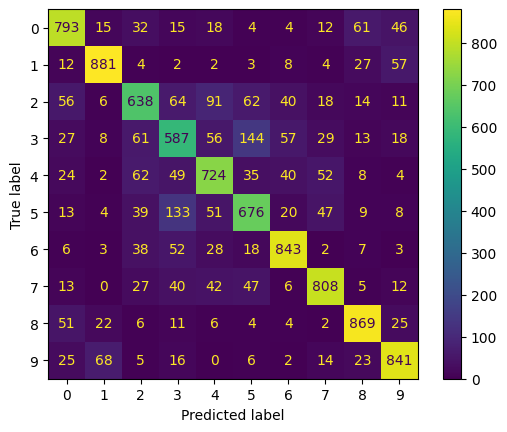

In [109]:
test_model(model_custom,device,test_dataloader)

In [110]:
# checking Resnet50 Model's performance
path = r"C:\Users\satya\Downloads\Runs\training_weights\Best_Model_with_overlay_0.0004_resnet_50_22.pt"
model_resnet50_new = initialize_segmentation_model(checkpoint_path = path)

Testing...


(79/79) | Data: 0.049s | Batch: 0.080s | GPU usage: 1.892 GB: 100%|██████████| 79/79 [00:06<00:00, 12.44it/s]


testing accuracy: 0.83140
testing precision: 0.83117
testing recall: 0.83140
testing F1-Score: 0.83111


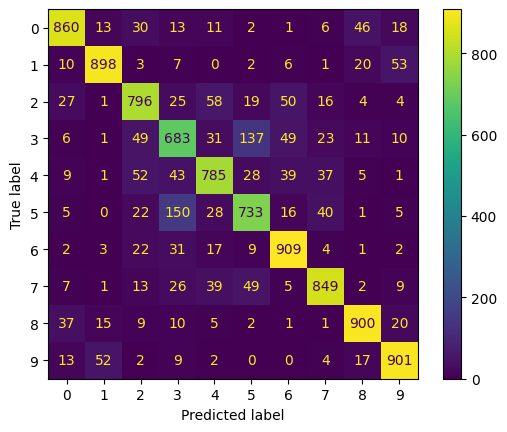

In [111]:
test_model(model_resnet50,device,test_dataloader)